In [2]:
import pandas as pd

In [6]:
df = pd.read_csv("azureml://subscriptions/691b6bae-62e2-4c8b-bbcf-70bc1f0f528b/resourcegroups/storage-insurance/workspaces/ML-insurance/datastores/workspaceartifactstore/paths/insurance_dataset.csv")
df.head()

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,charges
0,46,male,21.45,5,yes,southeast,Diabetes,NaN,Never,Blue collar,Premium,20460.307669
1,25,female,25.38,2,yes,northwest,Diabetes,High blood pressure,Occasionally,White collar,Premium,20390.899218
2,38,male,44.88,2,yes,southwest,NaN,High blood pressure,Occasionally,Blue collar,Premium,20204.476302
3,25,male,19.89,0,no,northwest,NaN,Diabetes,Rarely,White collar,Standard,11789.029843
4,49,male,38.21,3,yes,northwest,Diabetes,High blood pressure,Rarely,White collar,Standard,19268.309838


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 12 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   age                     1000000 non-null  int64  
 1   gender                  1000000 non-null  object 
 2   bmi                     1000000 non-null  float64
 3   children                1000000 non-null  int64  
 4   smoker                  1000000 non-null  object 
 5   region                  1000000 non-null  object 
 6   medical_history         749238 non-null   object 
 7   family_medical_history  749596 non-null   object 
 8   exercise_frequency      1000000 non-null  object 
 9   occupation              1000000 non-null  object 
 10  coverage_level          1000000 non-null  object 
 11  charges                 1000000 non-null  float64
dtypes: float64(2), int64(2), object(8)
memory usage: 91.6+ MB


### Label Encoding categorical features

In [7]:
import json
from sklearn import preprocessing
def to_categorical(df, feature):
    le = preprocessing.LabelEncoder()
    le.fit(df[feature].unique())
    feature_cat = le.transform(df[feature])
    df.drop([feature], axis=1)
    df[feature] = feature_cat
    label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    return label_mapping

feature_mapping = {}

# Apply label encoding and store label mappings in the dictionary
feature_mapping['gender'] = to_categorical(df, 'gender')
feature_mapping['smoker'] = to_categorical(df, 'smoker')
feature_mapping['region'] = to_categorical(df, 'region')
feature_mapping['medical_history'] = to_categorical(df, 'medical_history')
feature_mapping['family_medical_history'] = to_categorical(df, 'family_medical_history')
feature_mapping['exercise_frequency'] = to_categorical(df, 'exercise_frequency')
feature_mapping['occupation'] = to_categorical(df, 'occupation')
feature_mapping['coverage_level'] = to_categorical(df, 'coverage_level')

Storing the labels for inference

In [9]:
converted_mappings = {}
for key, value in feature_mapping.items():
    converted_value = {k: int(v) for k, v in value.items()}
    converted_mappings[key] = converted_value

# Save the converted dictionary to a JSON file
with open('mappings.json', 'w') as json_file:
    json.dump(converted_mappings, json_file)

In [11]:
df.head()

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,charges
0,46,1,21.45,5,1,2,0,3,1,0,1,20460.307669
1,25,0,25.38,2,1,1,0,2,2,3,1,20390.899218
2,38,1,44.88,2,1,3,3,2,2,0,1,20204.476302
3,25,1,19.89,0,0,1,3,0,3,3,2,11789.029843
4,49,1,38.21,3,1,1,0,2,3,3,2,19268.309838


### Data Visualization

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'gender'}>,
        <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'children'}>,
        <Axes: title={'center': 'smoker'}>,
        <Axes: title={'center': 'region'}>],
       [<Axes: title={'center': 'medical_history'}>,
        <Axes: title={'center': 'family_medical_history'}>,
        <Axes: title={'center': 'exercise_frequency'}>],
       [<Axes: title={'center': 'occupation'}>,
        <Axes: title={'center': 'coverage_level'}>,
        <Axes: title={'center': 'charges'}>]], dtype=object)

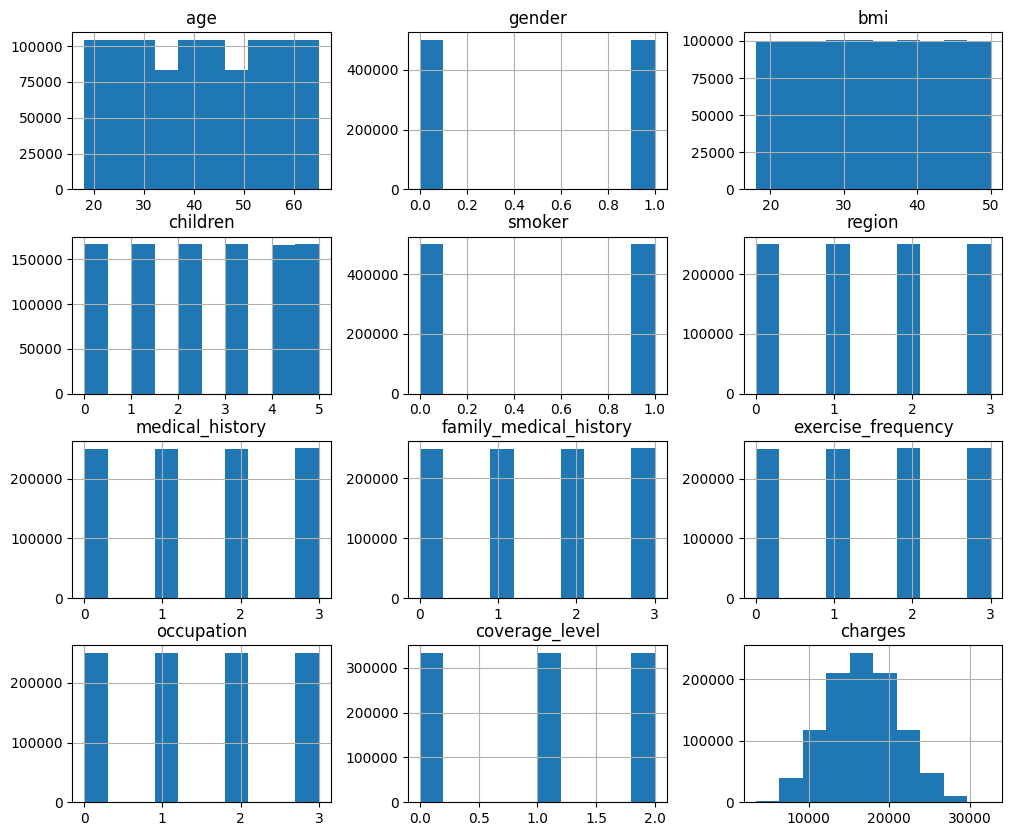

In [12]:
df.hist(figsize = (12,10))

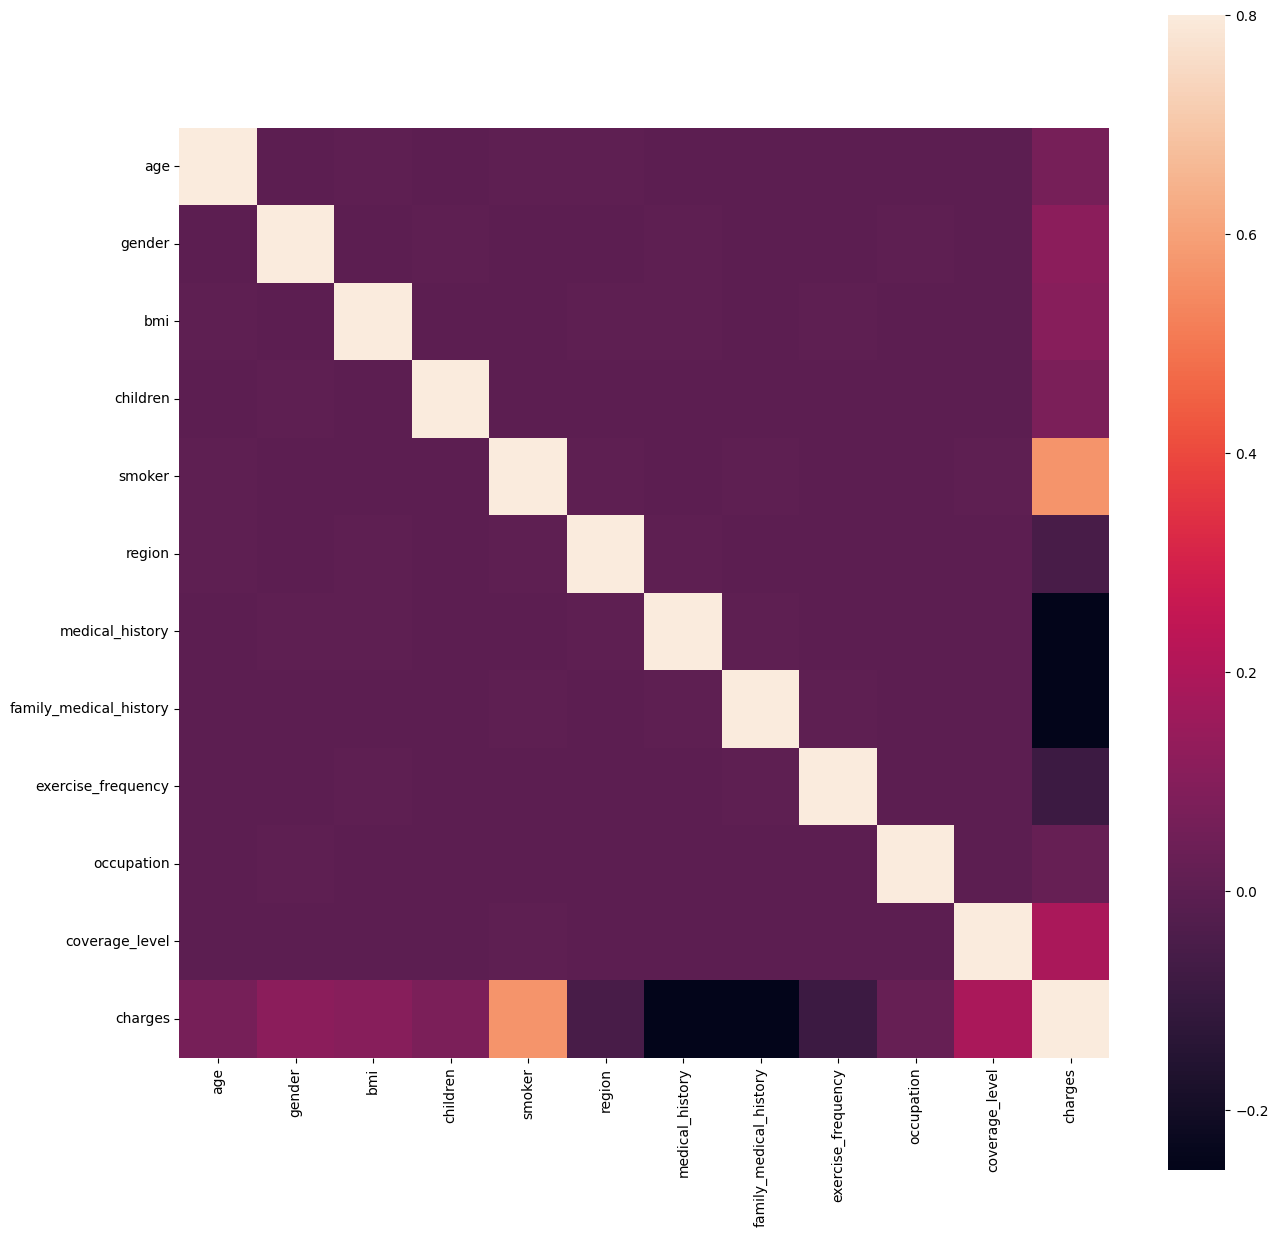

In [15]:
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
C_mat = df.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [10]:
# making sure none of the rows contain nan values
df.dropna(inplace=True)
len(df)

1000000

## Training

In [11]:
import seaborn as sns 
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import numpy as np

## Linear Rergression

In [12]:

x = df.loc[:, df.columns != 'charges']
y = df['charges']


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 100)
mlr = LinearRegression()  
mlr.fit(x_train, y_train)

#Prediction of test set
y_pred_mlr= mlr.predict(x_test)

meanAbErr = metrics.mean_absolute_error(y_test, y_pred_mlr)
meanSqErr = metrics.mean_squared_error(y_test, y_pred_mlr)
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_pred_mlr))
print('R squared: {:.2f}'.format(mlr.score(x, y)))
print('Mean Absolute Error:', meanAbErr)
print('Mean Square Error:', meanSqErr)
print('Root Mean Square Error:', rootMeanSqErr)

mlr_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': y_pred_mlr})
print(mlr_diff.corr())
print(mlr_diff.head())

R squared: 0.53
Mean Absolute Error: 2471.644882320318
Mean Square Error: 9144141.399951886
Root Mean Square Error: 3023.9281406726395
                 Actual value  Predicted value
Actual value          1.00000          0.72828
Predicted value       0.72828          1.00000
        Actual value  Predicted value
617759  13562.671654     13002.175044
693227  11907.598340     10257.650352
906065  11279.207498     12685.444616
828507   7493.732336     10543.186773
869730  20286.650682     16740.222955


## Random Forest

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import numpy as np
import pandas as pd

# Define the reverse normalization function
def reverse_normalization(column, mean, std):
    reversed_column = (column * std) + mean
    return reversed_column

# Assuming 'df' is your DataFrame

x = df.loc[:, df.columns != 'charges']
y = df['charges']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=100)

# Train the non-linear regression model (Random Forest)
n_estimators = 100  # You can adjust this parameter as needed
rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=100)
rf_model.fit(x_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(x_test)


# Calculate evaluation metrics
meanAbErr = metrics.mean_absolute_error(y_test, y_pred_rf)
meanSqErr = metrics.mean_squared_error(y_test, y_pred_rf)
rootMeanSqErr = np.sqrt(meanSqErr)

# Print evaluation metrics
print('Mean Absolute Error:', meanAbErr)
print('Mean Square Error:', meanSqErr)
print('Root Mean Square Error:', rootMeanSqErr)

# Create a DataFrame to compare predicted and actual values
rf_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': y_pred_rf})

# Calculate correlation and print first few rows
correlation = rf_diff.corr()
print(correlation)
print(rf_diff.head())

Mean Absolute Error: 300.68783046495696
Mean Square Error: 134237.19564538274
Root Mean Square Error: 366.38394567090785
                 Actual value  Predicted value
Actual value         1.000000         0.996549
Predicted value      0.996549         1.000000
        Actual value  Predicted value
617759  13562.671654     14166.935442
693227  11907.598340     11449.279946
906065  11279.207498     11161.322283
828507   7493.732336      8143.563607
869730  20286.650682     20614.727351


In [15]:
import joblib
joblib.dump(rf_model, 'trained_model.pkl')

['trained_model.pkl']